# Modeling 111001001 all features

In this notebook, we're specifically working on the dataset formed by dropping (31, 496, 524, 917, 1299) and keeping all.

In [1]:
import itertools
import numpy as np
import pandas as pd
import scipy
from scipy import optimize

pd.set_option('display.precision',20)
pd.set_option('display.max_colwidth',100)

from sklearn import linear_model, svm, tree
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_val_score, \
                                    GridSearchCV, RandomizedSearchCV, ShuffleSplit
from sklearn.neural_network import MLPRegressor
    
    
    
import xgboost as xgb

from time import time
from scipy.stats import randint as sp_randint

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from matplotlib import pyplot
rcParams['figure.figsize'] = 12, 4
%matplotlib inline

In [2]:
# def to compare goodness of fit on training set
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [4]:
# run randomized search
def random_search(regr, param_dist, n_iter_search): 
    rs = RandomizedSearchCV(regr, param_distributions=param_dist, scoring = 'neg_mean_squared_error',
                                   n_jobs=-1, n_iter=n_iter_search, cv=kfold) #, verbose = 4)
    start = time()
    rs.fit(x_train, y_train)
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
    report(rs.cv_results_)

In [5]:
# run single parameter search (for ridge or lasso)
def single_search(regr, params):
    regr_results_df = pd.DataFrame(dtype = 'float64')
    count = 0
    for k, v in params.items():
        for val in v:
            regr.set_params(**{k: val})
            regr_results_df.loc[count, k] = val
            results = cross_val_score(regr, x_train, y_train, cv=kfold, scoring = 'neg_mean_squared_error')
            (regr_results_df.loc[count, 'RMSE'], regr_results_df.loc[count, 'std dev']) = \
                    (np.sqrt(-results.mean()), np.sqrt(results.std()))
            count += 1
    return regr_results_df

In [6]:
# test against validation set
def validate(regr):
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_validation)
    return rmse(y_validation, y_pred)

In [7]:
# Cross-validation sets
kfold = KFold(n_splits=10, random_state=7)

In [8]:
df = pd.read_csv("./input/train_tidy_111001001.csv")

In [9]:
ss = ShuffleSplit(n_splits=1, test_size=0.20, random_state=71)

X = df.values

for train_idx, validation_idx in ss.split(X):
    train_df = df.iloc[train_idx]
    validation_df = df.iloc[validation_idx]
    
y_validation = validation_df['SalePrice'].values
x_validation = validation_df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values
y_train = train_df['SalePrice'].values
x_train = train_df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values

## Ridge regression

In [10]:
ridge_regr = linear_model.Ridge()

In [11]:
ridge_param = {'alpha': scipy.stats.expon(scale=10)}
random_search(ridge_regr, ridge_param, 20)

RandomizedSearchCV took 2.05 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.013 (std: 0.005)
Parameters: {'alpha': 7.9009215131973045}

Model with rank: 2
Mean validation score: -0.013 (std: 0.005)
Parameters: {'alpha': 8.7215176642633807}

Model with rank: 3
Mean validation score: -0.013 (std: 0.005)
Parameters: {'alpha': 7.5209737352345254}



,alpha,RMSE,std dev
0,1.0,0.11501077551067855065,0.07155303460995078579
1,2.0,0.11368612931297580881,0.07173119250372370082
2,3.0,0.11299065474074093673,0.07172791444907143654
3,4.0,0.11257228784249798115,0.07171432213688247459
13,14.0,0.11248354605770288783,0.07218465656875294734
12,13.0,0.11236779623349960056,0.07211467505691883384
4,5.0,0.11231476955103282533,0.07171565833694862335
11,12.0,0.11226506642760539223,0.07204644744715284210
10,11.0,0.11217813705536235080,0.07198068314478846264
5,6.0,0.11216192753078900457,0.07173373616531054930


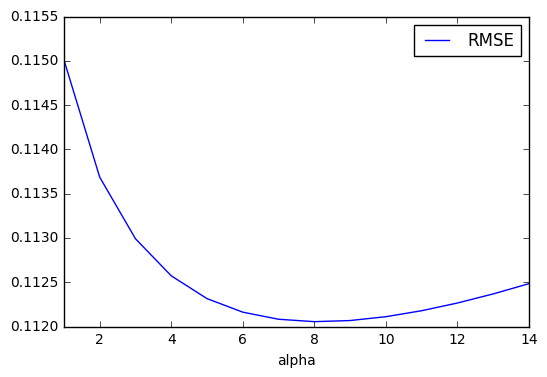

In [12]:
ridge_params = {'alpha': np.arange(1, 15, 1).tolist()}
ridge_df = single_search(ridge_regr, ridge_params)
ridge_df.plot(x = ['alpha'], y = ['RMSE'])
ridge_df.sort_values(['RMSE'], ascending = False)

In [13]:
ridge_regr = linear_model.Ridge(alpha = 8)

In [14]:
validate(ridge_regr)

0.10535446942266147

## Lasso

In [15]:
lasso_regr = linear_model.Lasso(max_iter=50000)

In [16]:
lasso_param = {'alpha': scipy.stats.expon(scale=0.001)}
random_search(lasso_regr, lasso_param, 20)

RandomizedSearchCV took 16.08 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.012 (std: 0.005)
Parameters: {'alpha': 0.00026314902031277773}

Model with rank: 2
Mean validation score: -0.012 (std: 0.005)
Parameters: {'alpha': 0.00032430955351745979}

Model with rank: 3
Mean validation score: -0.012 (std: 0.005)
Parameters: {'alpha': 0.00041621093354573657}



,alpha,RMSE,std dev
0,0.00010000000000000000,0.11205652193668920458,0.07316160995002023160
5,0.00060000000000000006,0.11059773176621763568,0.07295290174121758786
4,0.00050000000000000001,0.11008132760864929034,0.07281820631387497800
1,0.00020000000000000001,0.10976581259463141782,0.07352999840088217387
3,0.00040000000000000002,0.10969949216990884655,0.07290486272473960250
2,0.00030000000000000003,0.10958558378289821877,0.07337610546813473633


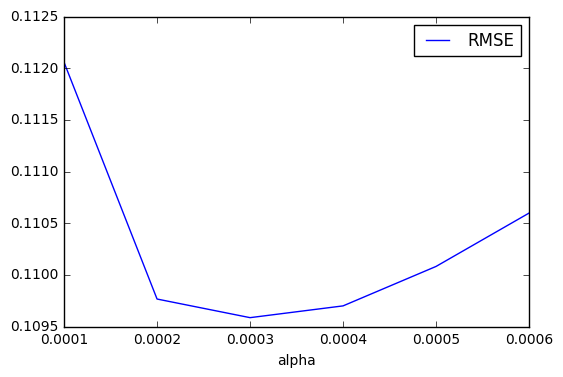

In [17]:
lasso_params = {'alpha': np.arange(0.0001, 0.0007, 0.0001).tolist()}
lasso_df = single_search(lasso_regr, lasso_params)
lasso_df.plot(x = ['alpha'], y = ['RMSE'])
lasso_df.sort_values(['RMSE'], ascending = False)

In [18]:
lasso_regr = linear_model.Lasso(alpha=0.0003, max_iter=50000)

In [19]:
validate(lasso_regr)

0.10135713687770388

## Lasso LARS

In [20]:
lassolars_regr = linear_model.LassoLars(max_iter=50000)

In [21]:
lassolars_param = {'alpha': scipy.stats.expon(scale=0.0001)}
random_search(lassolars_regr, lassolars_param, 20)

/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 225 iterations, i.e. alpha=1.985e-05, with an active set of 195 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 233 iterations, i.e. alpha=2.080e-05, with an active set of 189 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 304 iterations, i.e. alpha=9.037e-06, with an active set of 226 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model

RandomizedSearchCV took 5.29 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.012 (std: 0.005)
Parameters: {'alpha': 9.0720951188790776e-05}

Model with rank: 2
Mean validation score: -0.012 (std: 0.005)
Parameters: {'alpha': 0.000136435083493799}

Model with rank: 3
Mean validation score: -0.012 (std: 0.005)
Parameters: {'alpha': 6.8456036571861204e-05}



,alpha,RMSE,std dev
5,0.00013000000000000002,0.10773079430400411827,0.07186350745617245406
0,0.00008000000000000001,0.10766216306497913835,0.07111109469659264437
4,0.00012000000000000000,0.10760933646096443317,0.07164174981388483909
3,0.00011000000000000000,0.10755502116014487024,0.07139087293496064468
1,0.00009000000000000001,0.10752450562173758442,0.07110021980322368818
2,0.00010000000000000000,0.10749885181230134368,0.07118740969115024131


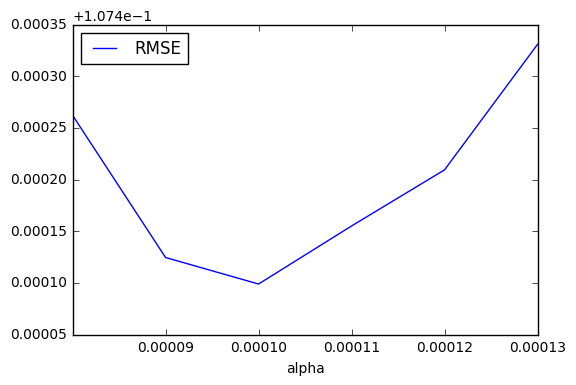

In [22]:
lassolars_params = {'alpha': np.arange(0.00008, 0.00014, 0.00001).tolist()}
lassolars_df = single_search(lassolars_regr, lassolars_params)
lassolars_df.plot(x = ['alpha'], y = ['RMSE'])
lassolars_df.sort_values(['RMSE'], ascending = False)

In [23]:
lassolars_regr = linear_model.LassoLars(alpha=0.0001, max_iter=50000)

In [24]:
validate(lassolars_regr)

0.098941493192865215

## Elastic Net

In [25]:
elnet_regr = linear_model.ElasticNet(max_iter=15000, random_state=7)

In [26]:
elnet_param =  {'alpha': scipy.stats.expon(scale=0.001), 'l1_ratio': scipy.stats.truncnorm(0, 1, loc=0.5, scale=0.25)}
random_search(elnet_regr, elnet_param, 20)

RandomizedSearchCV took 17.29 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.012 (std: 0.005)
Parameters: {'alpha': 0.00039125441431021743, 'l1_ratio': 0.69996574387944599}

Model with rank: 2
Mean validation score: -0.012 (std: 0.005)
Parameters: {'alpha': 0.00040290138713163707, 'l1_ratio': 0.64149926100728949}

Model with rank: 3
Mean validation score: -0.012 (std: 0.005)
Parameters: {'alpha': 0.0004750993237890934, 'l1_ratio': 0.68955508489722195}



,alpha,RMSE,std dev
0,0.00010000000000000000,0.11457652506643950518,0.07211236494335829250
1,0.00020000000000000001,0.11196095949423619242,0.07303538354860265869
2,0.00030000000000000003,0.11050144328158506557,0.07338854971989844378
6,0.00070000000000000010,0.11013153056731893320,0.07280904726160954132
3,0.00040000000000000002,0.10997538536591705549,0.07345836020148795165
5,0.00060000000000000006,0.10994436522482503582,0.07306962241584950835
4,0.00050000000000000001,0.10990071704561413246,0.07336082616308819970


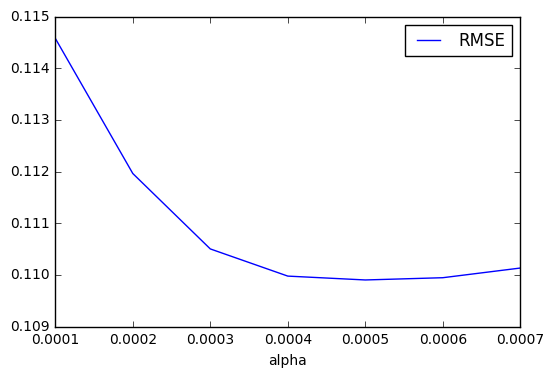

In [28]:
elnet_regr = linear_model.ElasticNet(alpha=0.00038, l1_ratio=0.5, max_iter=15000, random_state=7)
elnet_params = {'alpha': np.arange(0.0001, 0.0008, 0.0001).tolist()}
elnet_df = single_search(elnet_regr, elnet_params)
elnet_df.plot(x = ['alpha'], y = ['RMSE'])
elnet_df.sort_values(['RMSE'], ascending = False)

,l1_ratio,RMSE,std dev
0,0.10000000000000000555,0.11315881668763839996,0.07194278677589432958
1,0.20000000000000001110,0.11145839004748235579,0.07278189163886278346
2,0.30000000000000004441,0.11046158142181916606,0.07317677619216295115
3,0.40000000000000002220,0.10999216050819793367,0.07332531337113701309
8,0.90000000000000002220,0.10997274375503413024,0.07279857432526000427
6,0.70000000000000006661,0.10993175594813867080,0.07300354684855718534
7,0.80000000000000004441,0.10992423882988985873,0.07284305109628980146
4,0.50000000000000000000,0.10990071704561413246,0.07336082616308819970
5,0.59999999999999997780,0.10985540267425221439,0.07318211901253444951


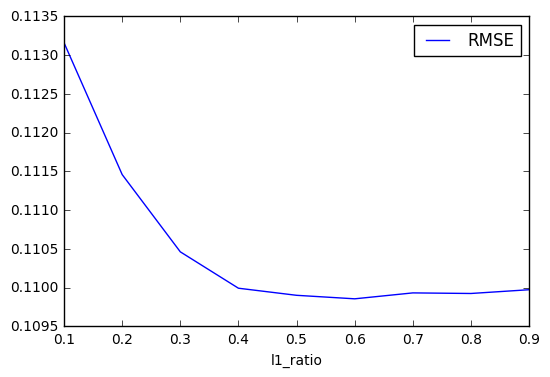

In [29]:
elnet_regr = linear_model.ElasticNet(alpha=0.0005, max_iter=15000, random_state=7)
elnet_params = {'l1_ratio': np.arange(0.1, 1, 0.1).tolist()}
elnet_df = single_search(elnet_regr, elnet_params)
elnet_df.plot(x = ['l1_ratio'], y = ['RMSE'])
elnet_df.sort_values(['RMSE'], ascending = False)

In [30]:
elnet_regr = linear_model.ElasticNet(alpha=0.0005, l1_ratio=0.6, max_iter=15000, random_state=7)

In [31]:
validate(elnet_regr)

0.10126049525676145

## Random Forest

In [32]:
rf_regr = RandomForestRegressor(n_jobs=-1, random_state = 7)

In [33]:
rf_param =  {'n_estimators': scipy.stats.randint(50,400), 'max_depth': scipy.stats.randint(2,20), 
             'max_features': scipy.stats.randint(5,30)}
random_search(rf_regr, rf_param, 20)

RandomizedSearchCV took 81.64 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.016 (std: 0.006)
Parameters: {'max_features': 25, 'n_estimators': 361, 'max_depth': 15}

Model with rank: 2
Mean validation score: -0.016 (std: 0.006)
Parameters: {'max_features': 21, 'n_estimators': 133, 'max_depth': 15}

Model with rank: 3
Mean validation score: -0.016 (std: 0.006)
Parameters: {'max_features': 24, 'n_estimators': 319, 'max_depth': 14}



,n_estimators,RMSE,std dev
1,110.0,0.12634047517723279164,0.07482706742890514462
9,190.0,0.12631839570828795605,0.07570577887821977603
0,100.0,0.12628011769946340115,0.07463673734160160278
8,180.0,0.12619315528642918722,0.07562052469320992842
2,120.0,0.12617830627128648335,0.07468365236526604278
7,170.0,0.12600056412028312613,0.07552665097367533553
3,130.0,0.12593842582735420565,0.07502348665473738965
6,160.0,0.12589192574289798099,0.07503541701168862932
4,140.0,0.12584769198066614315,0.07497942169252337641
5,150.0,0.12584072592069137086,0.07485809506595511587


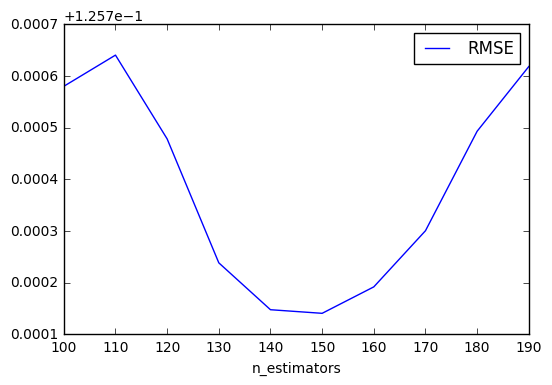

In [62]:
rf_regr = RandomForestRegressor(n_estimators = 361, max_depth = 15, max_features = 55, random_state = 7)
rf_params = {'n_estimators': np.arange(100, 200, 10).tolist()}
rf_df = single_search(rf_regr, rf_params)
rf_df.plot(x = ['n_estimators'], y = ['RMSE'])
rf_df.sort_values(['RMSE'], ascending = False)

In [65]:
rf_regr = RandomForestRegressor(n_estimators = 150, max_depth = 15, max_features = 55, random_state = 7)

In [66]:
validate(rf_regr)

0.11197281380880077

## Support Vector Regressor

In [34]:
svr_regr = svm.SVR(cache_size=200, degree=3, max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [35]:
svr_param = {'C': scipy.stats.expon(scale=1), 'gamma': scipy.stats.expon(scale=.1),
              'kernel': ['rbf']}
random_search(svr_regr, svr_param, 20)

RandomizedSearchCV took 18.21 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.014 (std: 0.006)
Parameters: {'kernel': 'rbf', 'C': 0.8033561560780772, 'gamma': 0.0072389962322271136}

Model with rank: 2
Mean validation score: -0.014 (std: 0.006)
Parameters: {'kernel': 'rbf', 'C': 0.9782389227171141, 'gamma': 0.012383974788519707}

Model with rank: 3
Mean validation score: -0.015 (std: 0.006)
Parameters: {'kernel': 'rbf', 'C': 1.3853534023178293, 'gamma': 0.013650805090784465}



,C,RMSE,std dev
0,0.5,0.12169488913644177508,0.07560050261562684115
7,4.0,0.12015588064032940718,0.07482910013823756978
6,3.5,0.11931856610188845691,0.07471149333564379436
5,3.0,0.11860129420001248868,0.07452709682199525065
1,1.0,0.11808022747557943288,0.07406512117257084415
4,2.5,0.11792582010034299844,0.07418541003171316706
3,2.0,0.11750952335302047858,0.07387091718780669503
2,1.5,0.11743514853885274329,0.07385686083666358204


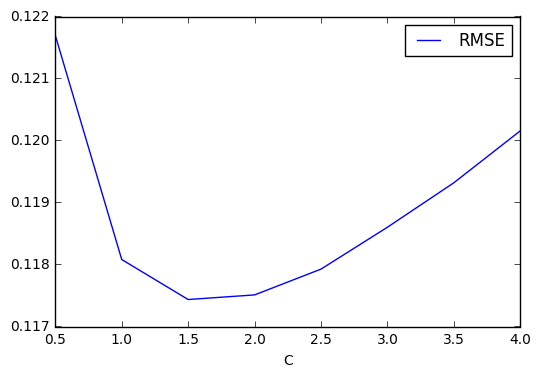

In [46]:
svr_regr = svm.SVR(C=0.8, cache_size=200, coef0=0.0, degree=3, gamma=0.007,
                        kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
svr_params = {'C': np.arange(0.5, 4.5, 0.5).tolist()}
svr_df = single_search(svr_regr, svr_params)
svr_df.plot(x = ['C'], y = ['RMSE'])
svr_df.sort_values(['RMSE'], ascending = False)

In [52]:
svr_regr = svm.SVR(C=1.7, cache_size=200, coef0=0.0, degree=3, gamma=0.007,
                        kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [53]:
validate(svr_regr)

0.1106465797935008

## Orthogonal Matching Pursuit

In [36]:
omp_regr = linear_model.OrthogonalMatchingPursuit()

In [37]:
omp_param = {'n_nonzero_coefs': scipy.stats.randint(20,100)}
random_search(omp_regr, omp_param, 20)

RandomizedSearchCV took 2.22 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.014 (std: 0.005)
Parameters: {'n_nonzero_coefs': 99}

Model with rank: 2
Mean validation score: -0.014 (std: 0.005)
Parameters: {'n_nonzero_coefs': 96}

Model with rank: 2
Mean validation score: -0.014 (std: 0.005)
Parameters: {'n_nonzero_coefs': 96}



,n_nonzero_coefs,RMSE,std dev
3,78.0,0.11856640132062583326,0.06934538769409438752
2,77.0,0.11842844058988821754,0.06929377757408138050
1,76.0,0.11840693071201004172,0.06937261106777997677
49,124.0,0.11839326319880133509,0.07190293453759911968
46,121.0,0.11829587161517397809,0.07232268589397797265
48,123.0,0.11824899753975035011,0.07180247751338240947
47,122.0,0.11823247131888528494,0.07223101535574860677
8,83.0,0.11820234303158126676,0.07077092096214031292
0,75.0,0.11817128638843904520,0.06940175049902921889
10,85.0,0.11816169806992543601,0.06994321685463865401


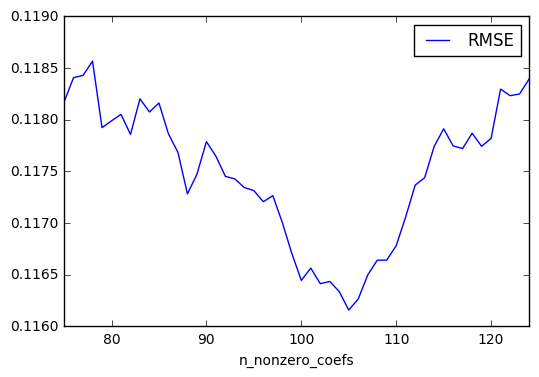

In [43]:
omp_regr = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=27)
omp_params = {'n_nonzero_coefs': np.arange(75, 125, 1).tolist()}
omp_df = single_search(omp_regr, omp_params)
omp_df.plot(x = ['n_nonzero_coefs'], y = ['RMSE'])
omp_df.sort_values(['RMSE'], ascending = False)

In [47]:
omp_regr = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=105)

In [48]:
validate(omp_regr)

0.10690126354879932

## XGBoost

In [38]:
xgb_regr = xgb.XGBRegressor(seed = 42, nthread = -1, silent = 1)
xgb_param = {'max_depth': scipy.stats.randint(1,10), # Max. Depth [1,∞]
             'min_child_weight': scipy.stats.expon(scale=1), # Min. Child Weight [0,∞]
             'gamma': scipy.stats.expon(scale=1), # Minimum Split Loss, gamma [0,∞]
             'subsample': scipy.stats.uniform(0, 1), # Subsample Ratio of the training instance [0,1]
             'colsample_bytree': scipy.stats.uniform(0, 1), # Subsample Ratio of columns [0,1]
             'reg_alpha': scipy.stats.expon(scale=1), # L1 regularization, alpha [0,∞]
             'reg_lambda': scipy.stats.expon(scale=1), # L2 regularization, lambda [0,∞]
             'learning_rate': scipy.stats.uniform(0, 1), # Step size shrinkage (learning rate) [0,1]
             'n_estimators': scipy.stats.randint(50,500) # Number of boosted trees, n_estimators
            }
random_search(xgb_regr, xgb_param, 20)

RandomizedSearchCV took 4689.88 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.016 (std: 0.006)
Parameters: {'reg_alpha': 0.42693674979872481, 'colsample_bytree': 0.68750110492379657, 'learning_rate': 0.085967482570634579, 'min_child_weight': 0.93996624676764662, 'n_estimators': 86, 'subsample': 0.19085631466173503, 'reg_lambda': 0.58589542995632771, 'max_depth': 6, 'gamma': 0.026295743039061452}

Model with rank: 2
Mean validation score: -0.018 (std: 0.006)
Parameters: {'reg_alpha': 0.56076184828209819, 'colsample_bytree': 0.92487258647176485, 'learning_rate': 0.3482556664293015, 'min_child_weight': 1.2909246918309529, 'n_estimators': 485, 'subsample': 0.50037033948863896, 'reg_lambda': 1.514834199251172, 'max_depth': 2, 'gamma': 0.22935174956734683}

Model with rank: 3
Mean validation score: -0.020 (std: 0.007)
Parameters: {'reg_alpha': 2.3532457208100022, 'colsample_bytree': 0.98425466780435433, 'learning_rate': 0.80491699108804782, 'min_c

,n_estimators,RMSE,std dev
0,100.0,0.11686882123128558564,0.07399984747787763384
6,700.0,0.11589064388955490348,0.07450747106375699147
7,800.0,0.11588639690280803929,0.07451012224375713755
10,1100.0,0.11587858818960578011,0.07447436048805501640
8,900.0,0.11587543119836861416,0.07457113042502123978
9,1000.0,0.11585705729667823694,0.07454048968846953283
5,600.0,0.11580692001098662203,0.07445847988064585588
4,500.0,0.11577634343914615378,0.07446746719618910215
3,400.0,0.11565835872049087807,0.07429208005440815499
1,200.0,0.11548125919433280262,0.07416919020423785869


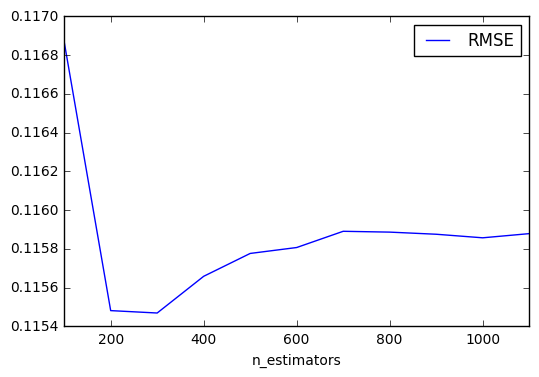

In [81]:
xgb_regr = xgb.XGBRegressor(
    max_depth = 5, 
    min_child_weight = 5.1,
    gamma = 0.01,
    subsample = 0.7,
    colsample_bytree = 0.5,
    reg_alpha = 0.25,
    reg_lambda = 0.024, 
    learning_rate = 0.09,
    n_estimators = 86,
    objective='reg:linear', 
    seed = 42,
    nthread = -1,
    silent = 1)
xgb_params = {'n_estimators': np.arange(100, 1200, 100).tolist()}
xgb_df = single_search(xgb_regr, xgb_params)
xgb_df.plot(x = ['n_estimators'], y = ['RMSE'])
xgb_df.sort_values(['RMSE'], ascending = False)

In [82]:
xgb_regr = xgb.XGBRegressor(
    max_depth = 5, 
    min_child_weight = 5.1,
    gamma = 0.01,
    subsample = 0.7,
    colsample_bytree = 0.5,
    reg_alpha = 0.25,
    reg_lambda = 0.024, 
    learning_rate = 0.09,
    n_estimators = 300,
    objective='reg:linear', 
    seed = 42,
    nthread = -1,
    silent = 1)

In [83]:
validate(xgb_regr)

0.10773024819475514

## MLP Regressor

In [39]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(100, ),
                        alpha=0.0001, 
                        tol=0.0001, 
                        max_iter=200)

In [40]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641)
mlp_param = {'hidden_layer_sizes': scipy.stats.randint(50,500), # size of a single hidden layer
             'alpha': scipy.stats.expon(scale=0.0001), # L2 regularization,  [0,∞]
             'tol': scipy.stats.expon(scale=0.0001), # Minimum improvement in loss fun. during training
             'max_iter': scipy.stats.uniform(200, 400), # Maximum number of iterations of solver
            }
random_search(mlp_regr, mlp_param, 20)

RandomizedSearchCV took 952.02 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.020 (std: 0.004)
Parameters: {'alpha': 0.0001021052396343698, 'max_iter': 293.74757561282149, 'tol': 0.00041843565829642338, 'hidden_layer_sizes': 240}

Model with rank: 2
Mean validation score: -0.020 (std: 0.004)
Parameters: {'alpha': 0.00039247300841600922, 'max_iter': 241.57014091809023, 'tol': 8.7533861048802575e-05, 'hidden_layer_sizes': 490}

Model with rank: 3
Mean validation score: -0.020 (std: 0.004)
Parameters: {'alpha': 6.6940936431545932e-05, 'max_iter': 475.66532238663655, 'tol': 1.0846472137448972e-05, 'hidden_layer_sizes': 424}



,max_iter,RMSE,std dev
5,425.0,0.11843096971472240331,0.06811891816358764395
4,400.0,0.11835975401134470053,0.06804361733022562531
3,375.0,0.11815520626020353800,0.06712276397358472868
2,350.0,0.11810369398057284085,0.06723117080826086778
1,325.0,0.11792898394568439302,0.06709689647545591384
0,300.0,0.11724238920401276742,0.06693721082204857897


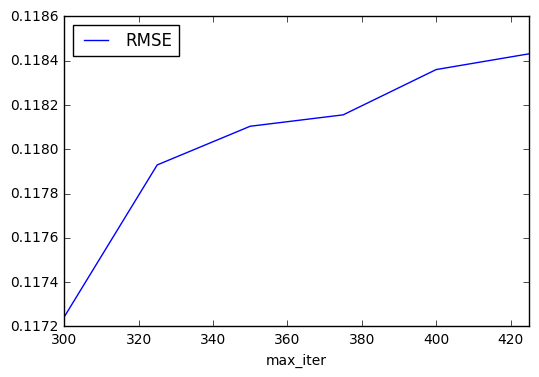

In [77]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(3, ),
                        alpha=0.00006, 
                        tol=0.00038, 
                        max_iter=293)
mlp_params = {'max_iter': np.arange(300, 450, 25).tolist()}
# mlp_params = {'tol': np.logspace(-5, -2, 12).tolist()}
mlp_df = single_search(mlp_regr, mlp_params)
mlp_df.plot(x = ['max_iter'], y = ['RMSE'])
mlp_df.sort_values(['RMSE'], ascending = False)

In [79]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(3, ),
                        alpha=0.00006, 
                        tol=0.00038, 
                        max_iter=300)

In [80]:
validate(mlp_regr)

0.1168122797201547